<a href="https://colab.research.google.com/github/shajeeraza12/Machine-Learning/blob/main/MLT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

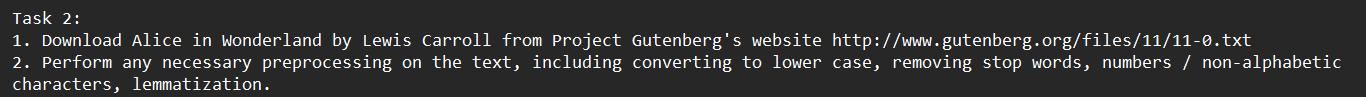

# Importing necessary libraries

In [1]:
import re
import requests
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import spacy

# Downloading necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# Fetching the file

In [2]:
# Downloading the text from Project Gutenberg
url = "http://www.gutenberg.org/files/11/11-0.txt"
response = requests.get(url)
if response.status_code == 200:
    text = response.text
    print("Text downloaded successfully.")
else:
    print("Failed to download the text.")


Text downloaded successfully.


# Removing the index

In [3]:
def preprocess_remove_index(text):
    text_lower = text.lower()

    lines = text.splitlines()

    # Finding the index of the first occurrence of "CHAPTER XII"
    for i, line in enumerate(lines):
        if 'chapter xii' in line.lower():
            chapter_xii_index = i
            break
    else:
        print("First occurrence of 'CHAPTER XII' not found.")
        return text

    # Removing everything up to and including the line with "CHAPTER XII"
    cleaned_lines = lines[chapter_xii_index + 1:]

    # Joining the remaining lines back into a single string
    cleaned_text = "\n".join(cleaned_lines)

    return cleaned_text

processed_text = preprocess_remove_index(text)
print("Index removed. Proceeding with text.")

Index removed. Proceeding with text.


In [4]:
processed_text

'\n\n\n\nCHAPTER I.\nDown the Rabbit-Hole\n\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into\nthe book her sister was reading, but it had no pictures or\nconversations in it, “and what is the use of a book,” thought Alice\n“without pictures or conversations?”\n\nSo she was considering in her own mind (as well as she could, for the\nhot day made her feel very sleepy and stupid), whether the pleasure of\nmaking a daisy-chain would be worth the trouble of getting up and\npicking the daisies, when suddenly a White Rabbit with pink eyes ran\nclose by her.\n\nThere was nothing so _very_ remarkable in that; nor did Alice think it\nso _very_ much out of the way to hear the Rabbit say to itself, “Oh\ndear! Oh dear! I shall be late!” (when she thought it over afterwards,\nit occurred to her that she ought to have wondered at this, but at the\ntime it all seemed quite natural); but when the Rabbit actual

# Finding chapter markers

In [5]:
processed_text_lower = processed_text.lower()
chapter_markers = re.findall(r'chapter [ivxlc]+\.', processed_text_lower)

# Checking if we found exactly 12 chapter markers
if len(chapter_markers) != 12:
    print(f"Warning: Found {len(chapter_markers)} chapter markers. Expected 12.")
else:
    print(f"Found the expected 12 chapter markers: {chapter_markers}")

# Locating chapter positions in the text based on chapter markers
chapter_positions = [processed_text_lower.find(marker) for marker in chapter_markers]
chapter_positions.append(len(processed_text_lower))

Found the expected 12 chapter markers: ['chapter i.', 'chapter ii.', 'chapter iii.', 'chapter iv.', 'chapter v.', 'chapter vi.', 'chapter vii.', 'chapter viii.', 'chapter ix.', 'chapter x.', 'chapter xi.', 'chapter xii.']


# Splitting the text into chapters

In [6]:
def split_into_chapters(text):
    # Regular expression to match chapter markers (e.g., "CHAPTER I.", "CHAPTER II.", etc.)
    chapter_pattern = re.compile(r'(chapter \w+\.)')

    # Finding all chapter markers positions
    chapter_positions = [match.start() for match in chapter_pattern.finditer(text.lower())]

    # Splitting the text into chapters using the found positions
    chapters = []
    for i in range(len(chapter_positions)):
        start_pos = chapter_positions[i]
        end_pos = chapter_positions[i+1] if i+1 < len(chapter_positions) else len(text)
        chapter_text = text[start_pos:end_pos].strip()
        chapters.append(chapter_text)

    return chapters

chapters = split_into_chapters(processed_text)
print(f"Total chapters detected: {len(chapters)}")

Total chapters detected: 12


# Preprocessing Text for TF-IDF (Tokenization, Lemmatization, etc.)

In [7]:
def preprocess_for_tfidf(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove punctuation and stopwords
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    processed_tokens = [
        lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()
    ]

    return ' '.join(processed_tokens)

# Preprocess each chapter for TF-IDF
preprocessed_chapters = [preprocess_for_tfidf(chapter) for chapter in chapters]

# Preprocessing text to exclude 'Alice' and other common stopwords

In [8]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphabetic characters and digits
    text = ''.join([char if char.isalpha() or char.isspace() else ' ' for char in text])

    # Process with SpaCy NLP model for POS tagging
    doc = nlp(text)

    # Filter out stop words and keep only nouns and adjectives, exclude 'alice'
    filtered_tokens = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ'] and token.text != 'alice']

    return " ".join(filtered_tokens)

# Apply the preprocessing function to all chapters
preprocessed_chapters = [preprocess_text(chapter) for chapter in chapters]

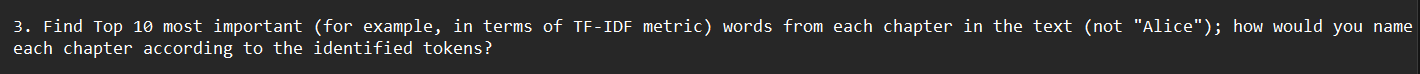

# Detecting top 10 words

In [38]:
from collections import Counter

# Function to get top N words (nouns + adjectives)
def get_top_n_words(chapter_text, n=10):
    doc = nlp(chapter_text)
    # Extract nouns and adjectives
    words = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]
    word_freq = Counter(words)
    top_words = [word for word, _ in word_freq.most_common(n)]  # Get only the words, not the counts
    return top_words

# Get top 10 words (nouns and adjectives) for each chapter
top_words_per_chapter = [get_top_n_words(chapter, n=10) for chapter in preprocessed_chapters]

# Print top words for each chapter, focusing on nouns and adjectives
for i, top_words in enumerate(top_words_per_chapter):
    print(f"Chapter {i+1}: {', '.join(top_words)}")

Chapter 1: little, way, rabbit, time, door, key, things, table, moment, people
Chapter 2: little, way, dear, pool, feet, things, mouse, cats, poor, great
Chapter 3: mouse, dodo, race, long, thing, birds, question, little, dry, lory
Chapter 4: little, rabbit, thing, window, bill, sure, great, door, voice, moment
Chapter 5: caterpillar, pigeon, little, serpent, last, bit, other, time, mouth, day
Chapter 6: cat, duchess, baby, mad, little, door, large, way, other, thing
Chapter 7: hatter, time, dormouse, tea, thing, little, same, table, great, twinkle
Chapter 8: head, queen, soldiers, game, voice, executioner, tone, moment, rabbit, procession
Chapter 9: turtle, mock, duchess, gryphon, little, day, moral, queen, old, thing
Chapter 10: mock, turtle, gryphon, dance, soup, beautiful, voice, sea, lobsters, tone
Chapter 11: king, court, witness, hatter, white, rabbit, jury, voice, little, other
Chapter 12: king, jury, little, white, rabbit, sister, head, dream, voice, important


Using these words, we can name the chapters as follows:

Chapter 1 - Through the door of time

Chapter 2 - Great Things and Poor Choices

Chapter 3 - A Race Among the Little Things

Chapter 4 - The Little Rabbit by the Window

Chapter 5- The Little Caterpillar and the Serpent

Chapter 6 - The Mad Duchess and the Little Cat

Chapter 7 - Tea at the Same Table

Chapter 8 - The Game of Execution and the Queen

Chapter 9 - The Mock Turtle and the Duchess

Chapter 10 - The Lobsters and the Dance of the Sea

Chapter 11 - The White Rabbit and the Witness

Chapter 12 - The Important Voice of the Jury


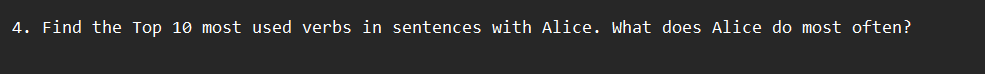

# Finding Top 10 Most Used Verbs in Sentences Containing "Alice"

In [37]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
import string

# Create an exclusion list for verbs
exclusion_list = ["getting", "being", "beginning", "having","speaking","saying","hanging"]  # Excluding unnecessary and repeated verbs

# Function to extract verbs from sentences containing 'Alice'
def extract_verbs_from_alice_sentences(text):
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)

    # Filter sentences containing the word "Alice"
    alice_sentences = [sentence for sentence in sentences if 'alice' in sentence.lower()]

    # Extract verbs from these sentences
    verbs = []
    for sentence in alice_sentences:
        tokens = word_tokenize(sentence)
        tagged_tokens = pos_tag(tokens)

        # Extract all verbs (tagged as VB, VBD, VBG, VBN, VBP, VBZ)
        verbs.extend([word for word, tag in tagged_tokens if tag.startswith('VB')])

    return verbs

# Extract verbs from sentences containing 'Alice'
alice_verbs = extract_verbs_from_alice_sentences(processed_text)

# Separate the verbs that are tagged as VBG (gerund or present participle)
vbg_verbs = [verb for verb in alice_verbs if pos_tag([verb])[0][1] == 'VBG']

# Remove excluded verbs from the list
vbg_verbs = [verb for verb in vbg_verbs if verb.lower() not in exclusion_list]

# Count the frequency of each VBG verb
vbg_verb_counts = Counter(vbg_verbs)

# Get the top 10 most frequent VBG verbs
top_10_vbg_verbs = vbg_verb_counts.most_common(10)

# Print the top 10 most frequent VBG verbs
print("Top 10 Most Frequent Verbs in Sentences with 'Alice' (Excluding List):")
for verb, count in top_10_vbg_verbs:
    print(f"{verb}: {count}")

Top 10 Most Frequent Verbs in Sentences with 'Alice' (Excluding List):
going: 18
looking: 16
talking: 10
trying: 8
turning: 7
feeling: 5
making: 4
thinking: 4
sitting: 3
wondering: 3
